In [1]:
# numerical / scientific
import numpy as np
import torch
import gpytorch as gp

# data
import pandas as pd
import pandas_datareader.data as web
import yfinance as yf

# plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 5)

# misc
import datetime
from typing import Tuple
from tqdm import tqdm

# utility  imports
from utilities.processing_utility import get_q_2_cw_data, get_train_test_split
from utilities.plotting_utility import plot_daily, plot_price_and_returns
from utilities.strategy_utilities import get_theta_and_V


# strategies imports
from strategies.ma_mean_reversion import get_ma_mean_reversion_signal
import strategies.gp_mean_reversion as gp_mean_reversion
from strategies.gp_mean_reversion import get_gp_mean_reversion_signal
from strategies.ma_breakout import get_ma_breakout_signal
import strategies.gp_breakout as gp_breakout
from strategies.gp_breakout import get_gp_breakout_signal


In [62]:
df = get_q_2_cw_data()
df.to_csv('cw_2_data.csv')

[*********************100%***********************]  1 of 1 completed


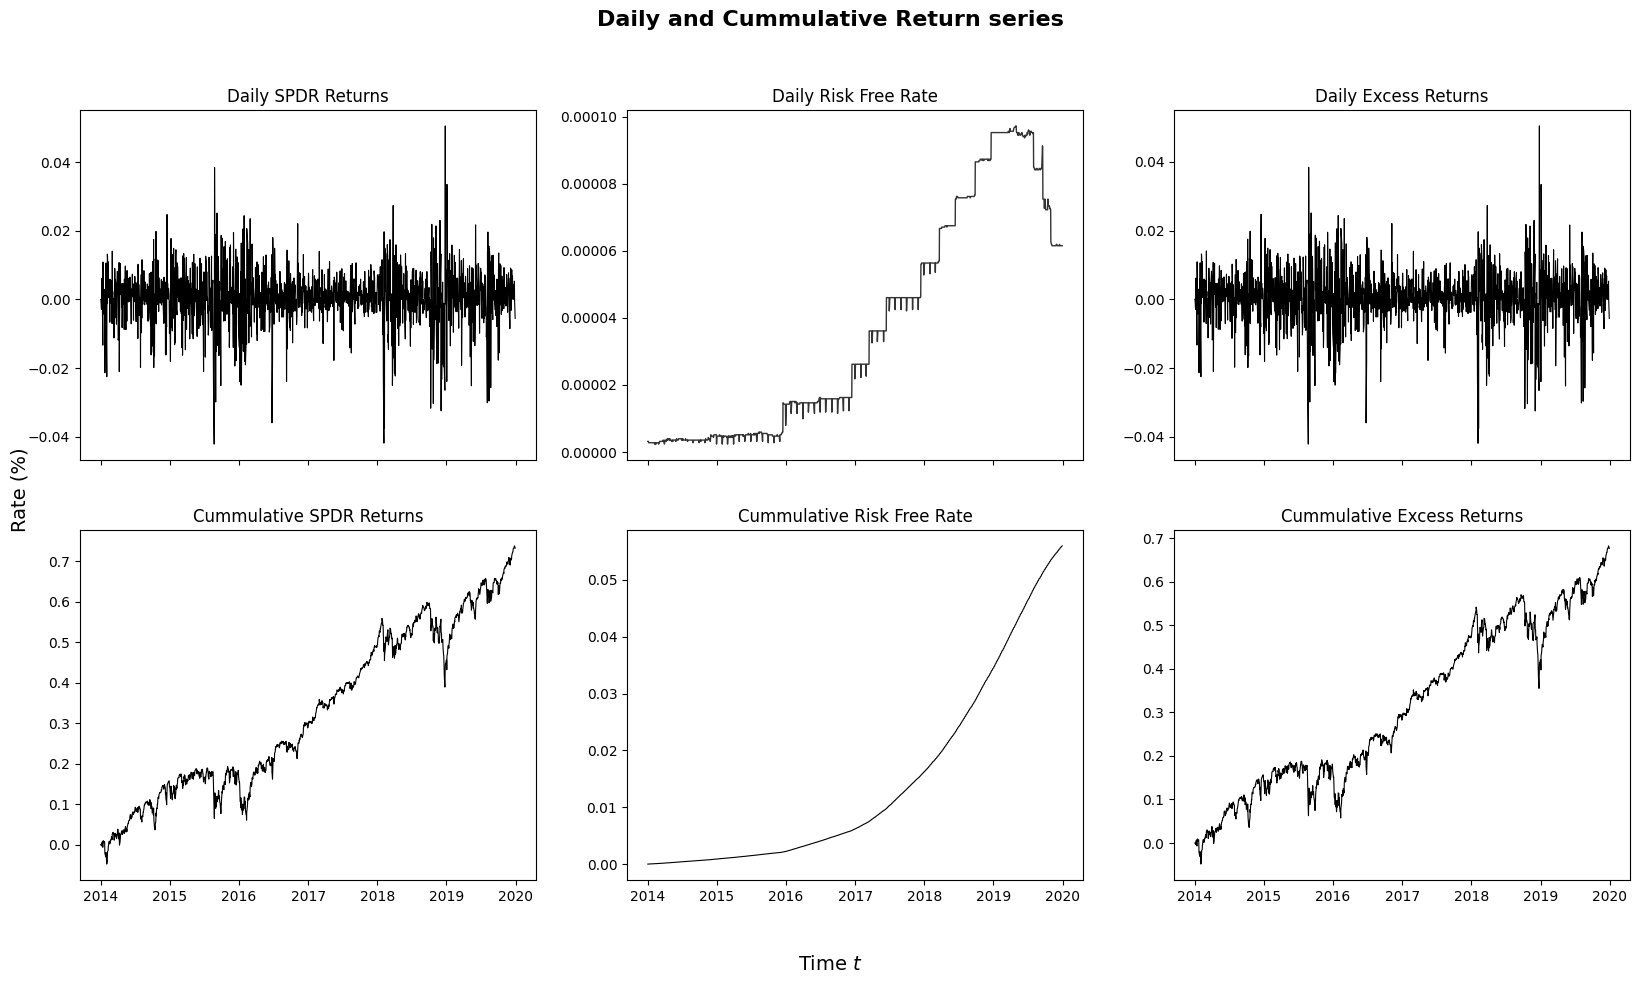

In [3]:
daily_returns_fig = plot_daily(df)

# save figure
daily_returns_fig.savefig('figures/01_daily_returns.png')

In [4]:
# get train test split
split_idx = int(len(df) * 0.7)
risk_free_rate_series = torch.tensor(df['daily_effr'].to_numpy(), dtype=torch.float32)
excess_return_data = torch.tensor(df['daily_excess_returns'].to_numpy(), dtype=torch.float32)
norm_excess_return_data = torch.tensor(df['normalised_excess_returns'].to_numpy(), dtype=torch.float32)
price_data = torch.tensor(df['adjusted_close_price'].to_numpy(), dtype=torch.float32)
x_data = torch.arange(0, len(price_data), dtype=torch.float32)

train_data, test_data = get_train_test_split(splitindex = split_idx, RFR = risk_free_rate_series, daily_R = excess_return_data, norm_R = norm_excess_return_data, P = price_data, X = x_data)

rfr_train, rfr_test = train_data['RFR'], test_data['RFR'] #  risk free rate
daily_r_train, daily_r_test = train_data['daily_R'], test_data['daily_R'] # daily excess returns
norm_r_train, norm_r_test = train_data['norm_R'], test_data['norm_R'] # normalised daily excess returns
p_train, p_test = train_data['P'], test_data['P'] # adjusted closing price
x_train, x_test = train_data['X'], test_data['X'] # x data


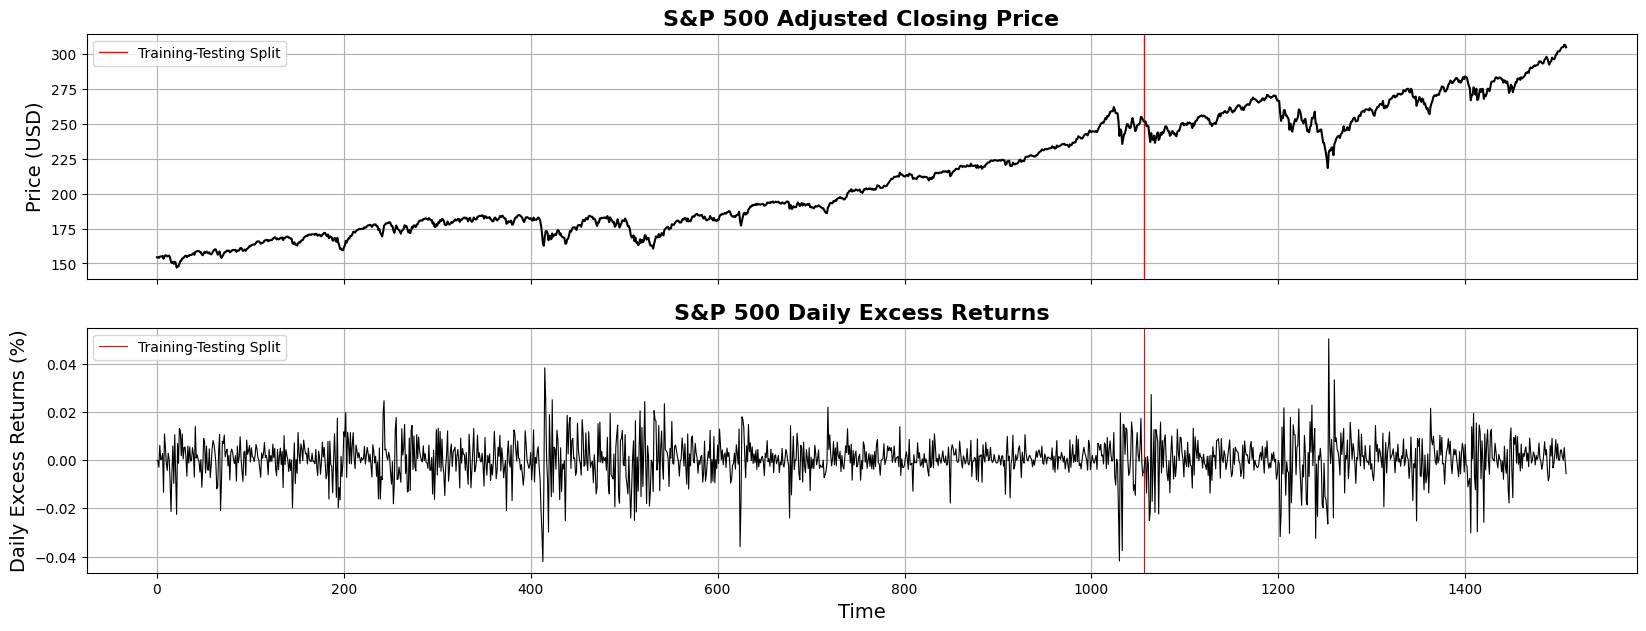

In [5]:
price_and_returns_fid = plot_price_and_returns(x_train, p_train, daily_r_train, x_test, p_test, daily_r_test)

# save figure
price_and_returns_fid.savefig('figures/02_price_and_returns_train_test_split.png')

In [6]:
# LONG ONLY 
train_lo_s = torch.ones_like(p_train)
test_lo_s = torch.ones_like(p_test)

In [7]:
# optimise the GP train signal
mr_lengthscale_hat, mr_noise_hat = gp_mean_reversion.optimise_marginal_likelihood(inputs=x_train, targets=norm_r_train, n_iter = 100)

       Iteration        |          Loss          |      Lengthscale       |         Noise          
           10           |   1.4014931917190552   |        0.64977         |        0.64933         
----------------------------------------------------------------------------------------------------
           20           |   1.391382098197937    |        0.60398         |        0.60398         
----------------------------------------------------------------------------------------------------
           30           |   1.3827327489852905   |        0.56118         |        0.56337         
----------------------------------------------------------------------------------------------------
           40           |   1.3771770000457764   |        0.52318         |        0.52765         
----------------------------------------------------------------------------------------------------
           50           |   1.3719501495361328   |        0.49049         |        0.49916      

In [8]:
# MEAN REVERSION SIGNAL - MOVING AVERAGE
train_mamr_s, train_mamr_bm, train_mamr_sm = get_ma_mean_reversion_signal(norm_r_train, 100)
test_mamr_s, test_mamr_bm, test_mamr_sm = get_ma_mean_reversion_signal(norm_r_test, 100)

# MEAN REVERSION SIGNAL - GAUSSIAN PROCESS
train_gpmr_s, train_gpmr_bm, train_gpmr_sm = get_gp_mean_reversion_signal(x_train, norm_r_train, lengthscale=2.5, noise=mr_noise_hat)
test_gpmr_s, test_gpmr_bm, test_gpmr_sm = get_gp_mean_reversion_signal(x_test, norm_r_test, lengthscale=2.5, noise=mr_noise_hat)

/var/folders/bd/shyl3h_n5bq3xz2xw1yv1jnm0000gp/T/ipykernel_60927/642348194.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax1.plot(x_train[99:], ma, 'b', lw = 1, color = 'steelblue', label = r'MA(100)')
/Users/maxnorman/UCL/term_2/comp0051_algorithmic_trading/comp0051_env/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
/var/folders/bd/shyl3h_n5bq3xz2xw1yv1jnm0000gp/T/ipykernel_60927/642348194.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax2.plot(x_train, f_preds.mean.detach().numpy(), 'b', lw = 1, color = 'steelblue', label = 'GP Mean')


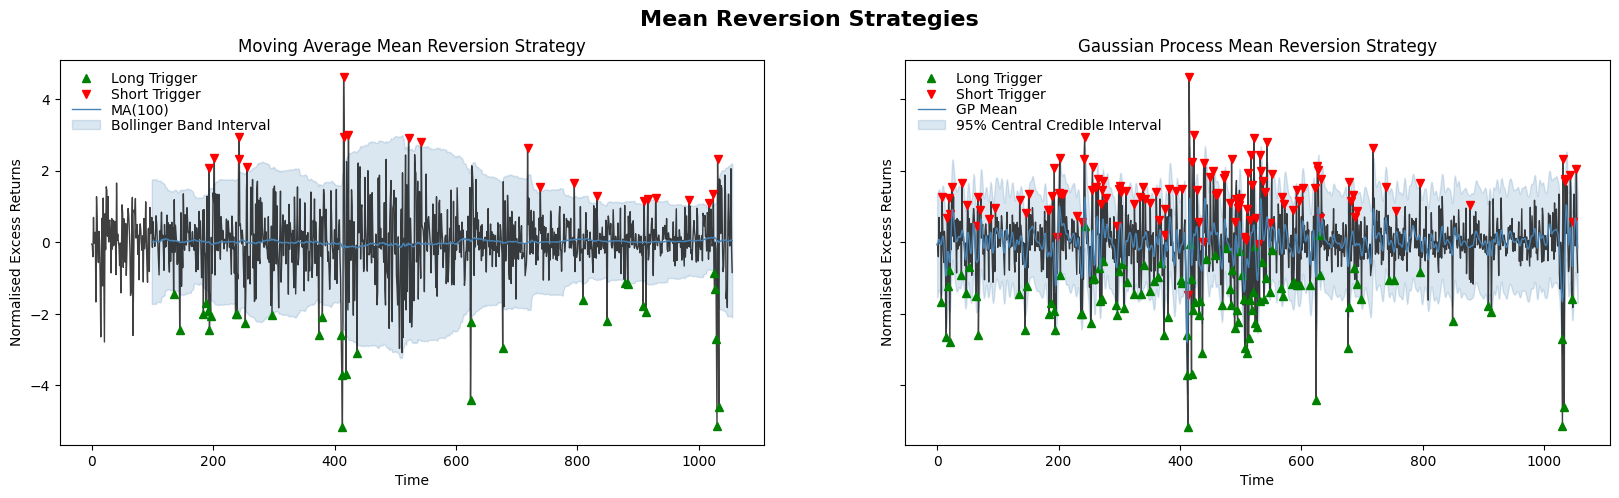

In [9]:
# plot strategies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)


ax1.plot(x_train, norm_r_train, 'black', lw = 1, alpha = .75)
ax1.plot(x_train[train_mamr_bm == 1.], norm_r_train[train_mamr_bm == 1], 'g^', label = 'Long Trigger')
ax1.plot(x_train[train_mamr_sm == 1], norm_r_train[train_mamr_sm == 1], 'rv', label = 'Short Trigger')
ax1.set_title('Moving Average Mean Reversion Strategy')
ax1.set_xlabel('Time')
ax1.set_ylabel('Normalised Excess Returns')


# plot MA & Bollinger Bands
ma = norm_r_train.unfold(0, 100, 1).mean(dim=1)
std = norm_r_train.unfold(0, 100, 1).std(dim=1)
ax1.plot(x_train[99:], ma, 'b', lw = 1, color = 'steelblue', label = r'MA(100)')
ax1.fill_between(x_train[99:], ma - 2*std, ma + 2*std, color = 'steelblue', alpha=0.2, label = 'Bollinger Band Interval')
ax1.legend(labelspacing=0.1, loc='upper left', frameon=False)

ax2.plot(x_train, norm_r_train, 'black', lw = 1, alpha = .75)
ax2.plot(x_train[train_gpmr_bm == 1.], norm_r_train[train_gpmr_bm == 1], 'g^', label = 'Long Trigger')
ax2.plot(x_train[train_gpmr_sm == 1], norm_r_train[train_gpmr_sm == 1], 'rv', label = 'Short Trigger')
ax2.set_title('Gaussian Process Mean Reversion Strategy')
ax2.set_xlabel('Time')
ax2.set_ylabel('Normalised Excess Returns')

# plot GP
constant_gp = gp_mean_reversion.get_constant_gp(x_train=x_train, y_train=norm_r_train, length_scale=2.5, noise=mr_noise_hat)
f_preds = gp_mean_reversion.get_gp_posterior(constant_gp, x_train)
lower, upper = f_preds.confidence_region()
ax2.plot(x_train, f_preds.mean.detach().numpy(), 'b', lw = 1, color = 'steelblue', label = 'GP Mean')
ax2.fill_between(x_train, lower.detach().numpy(), upper.detach().numpy(),color = 'steelblue', alpha=0.2, label = '95% Central Credible Interval')
ax2.legend(labelspacing=0.1, loc='upper left', frameon=False)

plt.suptitle('Mean Reversion Strategies', fontsize=16, fontweight='bold')

# saving figure
plt.savefig('figures/03_mean_reversion_strategies.png')

In [10]:
bo_lengthscale_hat, bo_noise_hat = gp_breakout.optimise_marginal_likelihood(x_train[:20], p_train[:20], 1000)

       Iteration        |          Loss          |      Lengthscale       |         Noise          
          100           |   376.76519775390625   |        3.60917         |        2.67104         
----------------------------------------------------------------------------------------------------
          200           |   238.9871368408203    |        4.61319         |        3.08087         
----------------------------------------------------------------------------------------------------
          300           |   180.38414001464844   |        5.34111         |        3.38474         
----------------------------------------------------------------------------------------------------
          400           |   146.83889770507812   |        5.92178         |        3.63463         
----------------------------------------------------------------------------------------------------
          500           |   124.61128997802734   |        6.40998         |        3.85155      

In [16]:
class ConstantGP(gp.models.ExactGP):
    """  GP with Linear Mean """
    
    def __init__(self, inputs, targets, likelihood):
        super(ConstantGP, self).__init__(inputs, targets, likelihood)
        self.mean_module = gp.means.constant_mean.ConstantMean()
        self.covar_module = gp.kernels.ScaleKernel(gp.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, covar_x)
    
    def get_posterior(self, test_inputs, confidenceregion = False):
        self.eval()
        with torch.no_grad(), gp.settings.fast_pred_var():
            f_preds = self(test_inputs)

        if confidenceregion:
            lower, upper = f_preds.confidence_region()
            return f_preds, lower, upper
        
        return f_preds

    def get_posterior_predictive(self, test_inputs, confidenceregion = False):
        # get posterior
        self.eval()
        with torch.no_grad(), gp.settings.fast_pred_var():
            observed_pred = self.likelihood(self(test_inputs))

        if confidenceregion:
            lower, upper = observed_pred.confidence_region()
            return observed_pred, lower, upper
        
        return observed_pred

In [31]:
def get_gp_breakout_signal(
    X : torch.Tensor,
    P : torch.Tensor,
    lengthscale : float = 2.5,
    noise : float = .5,
    window : int = 20,
    ) -> torch.Tensor:
    """
    Get the signal for a GP cross over strategy.

    Arguments:
    ----------
    X           : {torch.Tensor}
                    > The time series of the data.
    P           : {torch.Tensor}
                    > The time series of the prices.

    Returns:
    ----------
    signal      : {torch.Tensor}
                    > The signal for the GP cross over strategy.
    buy_mask    : {torch.Tensor}
                    > The mask for the buy signal.
    sell_mask   : {torch.Tensor}
    """
    # setp
    buy_mask = torch.zeros_like(X)
    sell_mask = torch.zeros_like(X)

    signal = torch.zeros_like(X)   

    upper_cci, lower_cci = torch.zeros_like(X), torch.zeros_like(X)
    gp_map = torch.zeros_like(X)
    gp_pred = torch.zeros_like(X)

    # sequential prediction
    for i, (x, p) in enumerate(zip(X, P)):
        
        if i <= window:
            signal[i] = 0
            continue

        # fit a GP to ths historica data
        n_start = i - window
        n_end = i 
        window_gp = ConstantGP(X[n_start:n_end], P[n_start:n_end], gp.likelihoods.GaussianLikelihood())

        window_gp.mean_module.constant = torch.mean(P[n_start:n_end])
        window_gp.covar_module.base_kernel.lengthscale = lengthscale
        window_gp.likelihood.noise = noise

        f_preds, lower, upper = window_gp.get_posterior(X[n_start:n_end], True)

        if i + 1 < len(X):
            f_test = window_gp.get_posterior_predictive(X[n_end+1].unsqueeze(-1), False).mean

        # upper_cci[i] = upper[-1]
        # lower_cci[i] = lower[-1]
        # gp_map[i] = f_preds.mean[-1].item()
        # gp_pred[i] = f_test.item()

        # if (p > lower[-1]) and (p < upper[-1]):
            
        #     if (signal[i-1] > 0) and (p > f_preds.mean[-1].item()):
        #         signal[i] = signal[i-1]

        #     elif (signal[i-1] < 0) and (p < f_preds.mean[-1].item()):
        #         signal[i] = signal[i-1]

        #     else:
        #         signal[i] = 0
        
        # # buy
        # elif p >= upper[-1]:
        #     buy_mask[i] = 1
        #     signal[i] = p - upper[-1]

        # # sell
        # elif p <= lower[-1]:
        #     sell_mask[i] = 1
        #     signal[i] = p - lower[-1]

        if f_test > p:
            signal[i] = 1

        elif f_test < p:
            signal[i] = -1

        else:
            signal[i] = 0

    return signal, buy_mask, sell_mask, gp_map, lower_cci, upper_cci, gp_pred

In [50]:
# BREAKOUT SIGNAL - MOVING AVERAGE
train_mabo_s, train_mabo_bm, train_mabo_sm = get_ma_breakout_signal(price_series = p_train, window_size = 20)
test_mabo_s, test_mabo_bm, test_mabo_sm = get_ma_breakout_signal(price_series = p_test, window_size = 20)

# BREAKOUT SIGNAL - GAUSSIAN PROCESS
train_gpbo_s, train_gpbo_bm, train_gpbo_sm, train_map, train_lower_cci, train_upper_cci, train_pred = get_gp_breakout_signal(x_train, p_train, lengthscale=5, noise=0.5, window=60)
test_gpbo_s, test_gpbo_bm, test_gpbo_sm, test_map, test_lower_cci, test_upper_cci, test_pred = get_gp_breakout_signal(x_test, p_test, lengthscale=0.5, noise=0.5, window=60)

/Users/maxnorman/UCL/term_2/comp0051_algorithmic_trading/comp0051_env/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:274: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


/var/folders/bd/shyl3h_n5bq3xz2xw1yv1jnm0000gp/T/ipykernel_60996/1278796009.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax1.plot(x_train[19:], ma, 'b', lw = 1, color = 'steelblue', label = r'MA(20)')
/var/folders/bd/shyl3h_n5bq3xz2xw1yv1jnm0000gp/T/ipykernel_60996/1278796009.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax2.plot(x_train[21:], train_map[21:], 'b', lw = 1, color = 'steelblue', label = 'GP MAP')


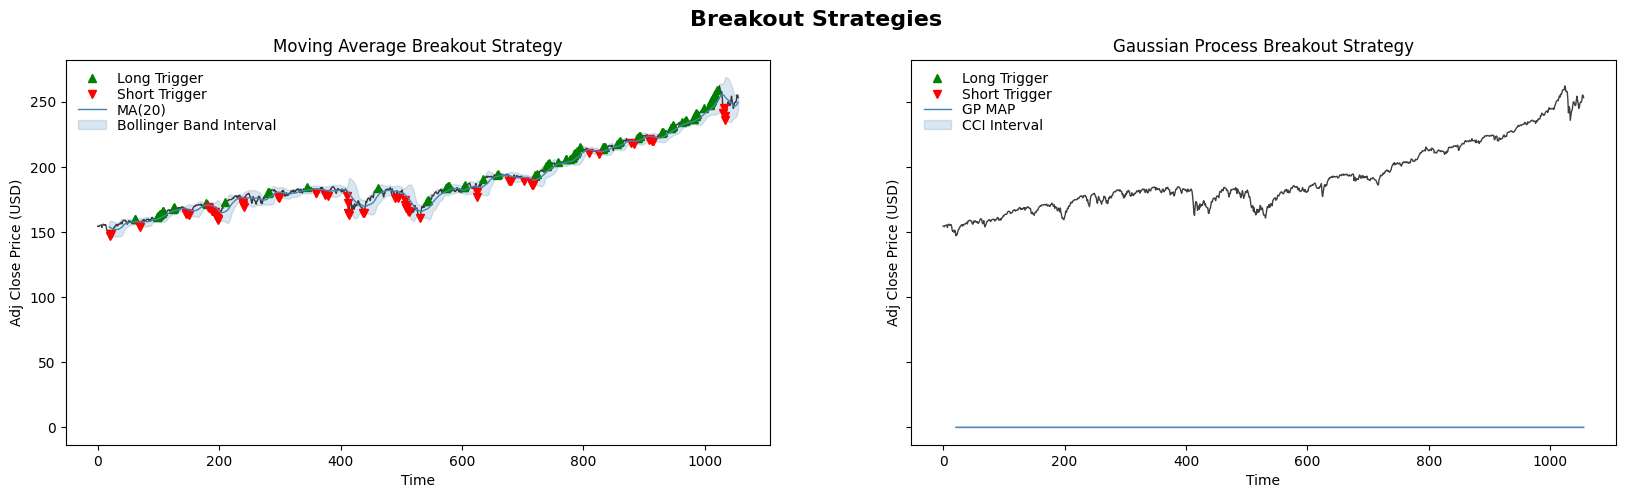

In [51]:
# plot strategies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)


ax1.plot(x_train, p_train, 'black', lw = 1, alpha = .75)
ax1.plot(x_train[train_mabo_bm == 1.], p_train[train_mabo_bm == 1], 'g^', label = 'Long Trigger')
ax1.plot(x_train[train_mabo_sm == 1], p_train[train_mabo_sm == 1], 'rv', label = 'Short Trigger')
ax1.set_title('Moving Average Breakout Strategy')
ax1.set_xlabel('Time')
ax1.set_ylabel('Adj Close Price (USD)')


# plot MA & Bollinger Bands
ma = p_train.unfold(0, 20, 1).mean(dim=1)
std = p_train.unfold(0, 20, 1).std(dim=1)
ax1.plot(x_train[19:], ma, 'b', lw = 1, color = 'steelblue', label = r'MA(20)')
ax1.fill_between(x_train[19:], ma - 2*std, ma + 2*std, color = 'steelblue', alpha=0.2, label = 'Bollinger Band Interval')
ax1.legend(labelspacing=0.1, loc='upper left', frameon=False)

ax2.plot(x_train, p_train, 'black', lw = 1, alpha = .75)
ax2.plot(x_train[train_gpbo_bm == 1.], p_train[train_gpbo_bm == 1], 'g^', label = 'Long Trigger')
ax2.plot(x_train[train_gpbo_sm == 1], p_train[train_gpbo_sm == 1], 'rv', label = 'Short Trigger')
ax2.set_title('Gaussian Process Breakout Strategy')
ax2.set_xlabel('Time')
ax2.set_ylabel('Adj Close Price (USD)')

# plot GP
ax2.plot(x_train[21:], train_map[21:], 'b', lw = 1, color = 'steelblue', label = 'GP MAP')
ax2.fill_between(x_train[21:], train_lower_cci[21:], train_upper_cci[21:], color = 'steelblue', alpha=0.2, label = 'CCI Interval')
ax2.legend(labelspacing=0.1, loc='upper left', frameon=False)

plt.suptitle('Breakout Strategies', fontsize=16, fontweight='bold')

# saving figure
plt.savefig('figures/04_breakout_strategies.png')

In [52]:
# GET LONG ONLY V
train_lo_strat = get_theta_and_V(daily_r_train, rfr_train , train_lo_s, initial_cash = 200_000., leverage = 5.)
test_lo_strat = get_theta_and_V(daily_r_test, rfr_test , test_lo_s, initial_cash = 200_000., leverage = 5.)

# # GET MEAN REVERSION - MOVING AVEARAGE
# train_mamr_strat = get_theta_and_V(daily_r_train, rfr_train , train_mamr_s, initial_cash = 200_000., leverage = 5.)
# test_mamr_strat = get_theta_and_V(daily_r_test, rfr_test , test_mamr_s, initial_cash = 200_000., leverage = 5.)

# # GET MEAN REVERSION - GAUSSIAN PROCESS
# train_gpmr_strat = get_theta_and_V(daily_r_train, rfr_train , train_gpmr_s, initial_cash = 200_000., leverage = 5.)
# test_gpmr_strat = get_theta_and_V(daily_r_test, rfr_test , test_gpmr_s, initial_cash = 200_000., leverage = 5.)

# GET BREAKOUT - MOVING AVEARAGE
train_mabo_strat = get_theta_and_V(daily_r_train, rfr_train , train_mabo_s, initial_cash = 200_000., leverage = 5.)
test_mabo_strat = get_theta_and_V(daily_r_test, rfr_test , test_mabo_s, initial_cash = 200_000., leverage = 5.)

# GET BREAKOUT - GAUSSIAN PROCESS
train_gpbo_strat = get_theta_and_V(daily_r_train, rfr_train , train_gpbo_s, initial_cash = 200_000., leverage = 5.)
test_gpbo_strat = get_theta_and_V(daily_r_test, rfr_test , test_gpbo_s, initial_cash = 200_000., leverage = 5.)

In [53]:
test_lo_strat.keys()

dict_keys(['theta', 'V_t', 'delta_V_t', 'V_cap', 'delta_V_cap', 'V_total', 'delta_V_total'])

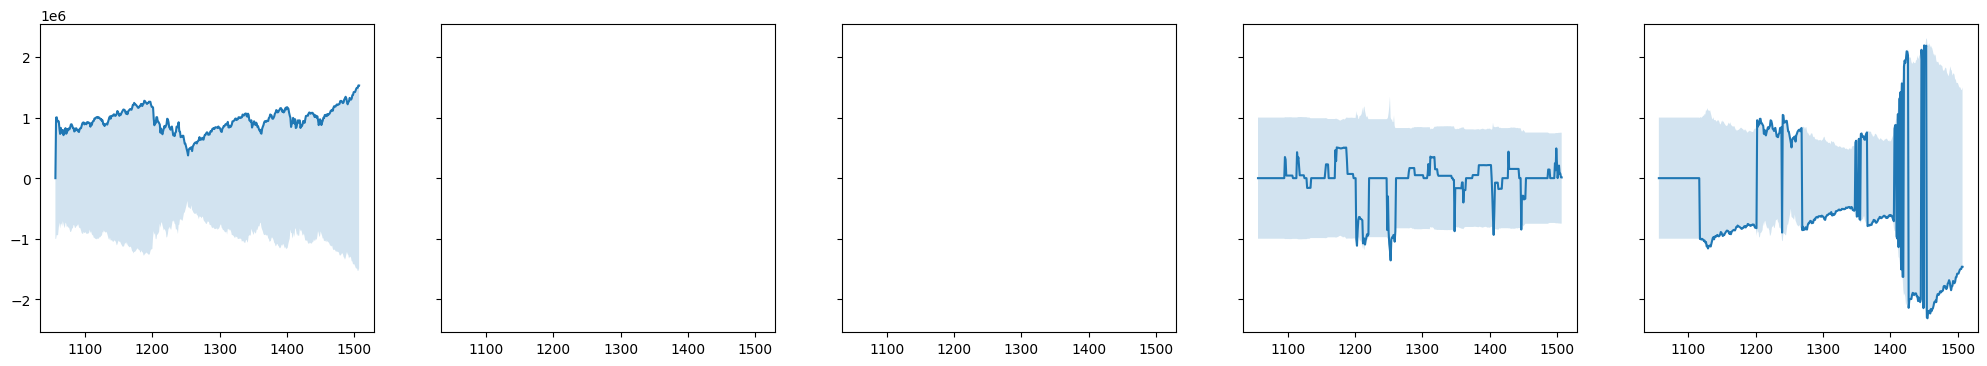

In [54]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25, 4), sharex=True, sharey=True)
L = 5

ax1.plot(x_test[:-1], test_lo_strat['theta'][:-1])
ax1.fill_between(x_test[:-1], L*test_lo_strat['V_t'][:-1], -L*test_lo_strat['V_t'][:-1], alpha=0.2)

# ax2.plot(x_test[:-1], test_mamr_strat['theta'][:-1])
# ax2.fill_between(x_test[:-1], L*test_mamr_strat['V_t'][:-1], -L*test_mamr_strat['V_t'][:-1], alpha=0.2)

# ax3.plot(x_test[:-1], test_gpmr_strat['theta'][:-1])
# ax3.fill_between(x_test[:-1], L*test_gpmr_strat['V_t'][:-1], -L*test_gpmr_strat['V_t'][:-1], alpha=0.2)

ax4.plot(x_test[:-1], test_mabo_strat['theta'][:-1])
ax4.fill_between(x_test[:-1], L*test_mabo_strat['V_t'][:-1], -L*test_mabo_strat['V_t'][:-1], alpha=0.2)

ax5.plot(x_test[:-1], test_gpbo_strat['theta'][:-1])
ax5.fill_between(x_test[:-1], L*test_gpbo_strat['V_t'][:-1], -L*test_gpbo_strat['V_t'][:-1], alpha=0.2)

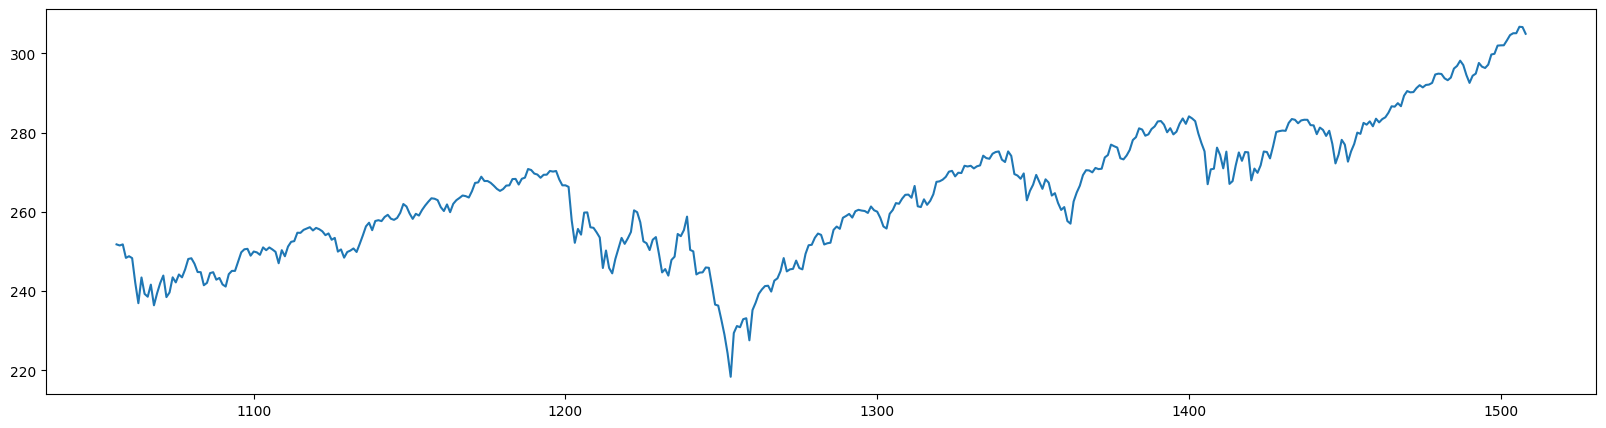

In [55]:
plt.plot(x_test, p_test)

In [56]:
test_lo_strat.keys()

dict_keys(['theta', 'V_t', 'delta_V_t', 'V_cap', 'delta_V_cap', 'V_total', 'delta_V_total'])

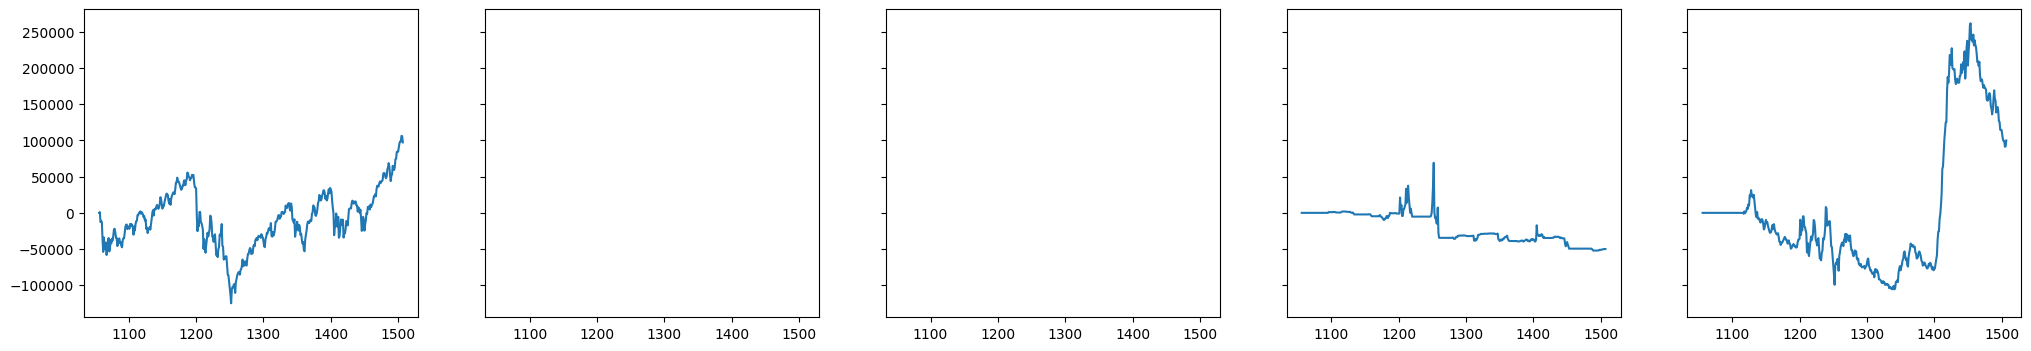

In [58]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(25, 4), sharex=True, sharey=True)

ax1.plot(x_test[:-1], np.cumsum(test_lo_strat['delta_V_t'][:-1]))


# ax2.plot(x_test[:-1],  np.cumsum(test_mamr_strat['delta_V_t'][:-1]))


# ax3.plot(x_test[:-1],  np.cumsum(test_gpmr_strat['delta_V_t'][:-1]))


ax4.plot(x_test[:-1],  np.cumsum(test_mabo_strat['delta_V_t'][:-1]))

ax5.plot(x_test[:-1],  np.cumsum(test_gpbo_strat['delta_V_t'][:-1]))


In [51]:
daily_r_train

tensor([-3.1746e-06, -1.6683e-04, -2.9010e-03,  ...,  1.7346e-02,
        -1.3116e-03, -6.5192e-03])

In [65]:
my_test_df = pd.DataFrame({
    'signal' : test_gpbo_s,
    'theta' : test_gpbo_strat['theta'],
    'V_t' : test_gpbo_strat['V_t'],
    'delta_V_t' : test_gpbo_strat['delta_V_t'],
    'V_cap' : test_gpbo_strat['V_cap'],
    'delta_V_cap' : test_gpbo_strat['delta_V_cap'],
    'V_total' : test_gpbo_strat['V_total'],
    'delta_V_total' : test_gpbo_strat['delta_V_total'],
    'price' : p_test,
    'exess_returns' : daily_r_test,
    'TIT' : torch.cat(
    ((p_test[:-1] * (1. + (daily_r_test[1:])), torch.tensor([0.]))
     ))})

my_train_df = pd.DataFrame({
    'signal' : train_gpbo_s,
    'theta' : train_gpbo_strat['theta'],
    'V_t' : train_gpbo_strat['V_t'],
    'delta_V_t' : train_gpbo_strat['delta_V_t'],
    'V_cap' : train_gpbo_strat['V_cap'],
    'delta_V_cap' : train_gpbo_strat['delta_V_cap'],
    'V_total' : train_gpbo_strat['V_total'],
    'delta_V_total' : train_gpbo_strat['delta_V_total'],
    'price' : p_train,
    'exess_returns' : daily_r_train,})


In [53]:
test_gpbo_strat.keys()

dict_keys(['theta', 'V_t', 'delta_V_t', 'V_cap', 'delta_V_cap', 'V_total', 'delta_V_total'])

In [59]:
class ConstantGP(gp.models.ExactGP):
    """  GP with Linear Mean """
    
    def __init__(self, inputs, targets, likelihood):
        super(ConstantGP, self).__init__(inputs, targets, likelihood)
        self.mean_module = gp.means.constant_mean.ConstantMean()
        self.covar_module = gp.kernels.ScaleKernel(gp.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, covar_x)
    
    def get_posterior(self, test_inputs, confidenceregion = False):
        self.eval()
        with torch.no_grad(), gp.settings.fast_pred_var():
            f_preds = self(test_inputs)

        if confidenceregion:
            lower, upper = f_preds.confidence_region()
            return f_preds, lower, upper
        
        return f_preds

    def get_posterior_predictive(self, test_inputs, confidenceregion = False):
        # get posterior
        self.eval()
        with torch.no_grad(), gp.settings.fast_pred_var():
            observed_pred = self.likelihood(self(test_inputs))

        if confidenceregion:
            lower, upper = observed_pred.confidence_region()
            return observed_pred, lower, upper
        
        return observed_pred

In [70]:
unfolded_tensor = p_train.unfold(0, 80, 1)
rolling_mean = unfolded_tensor.mean(dim=1)
rolling_std = unfolded_tensor.std(dim=1)


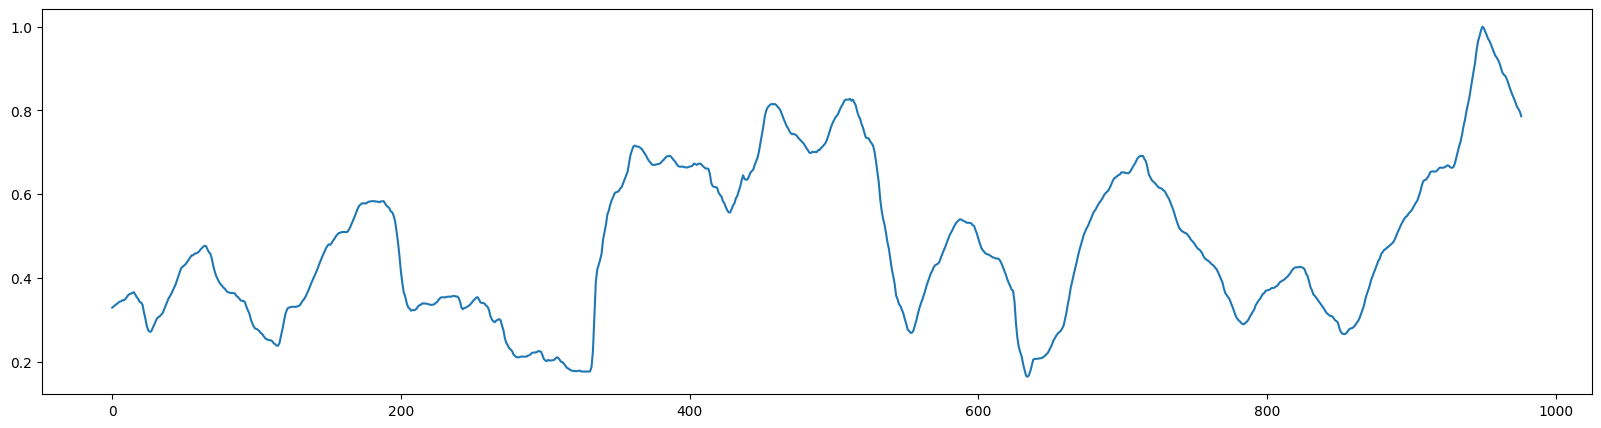

In [73]:
plt.plot(rolling_std / rolling_std.max())

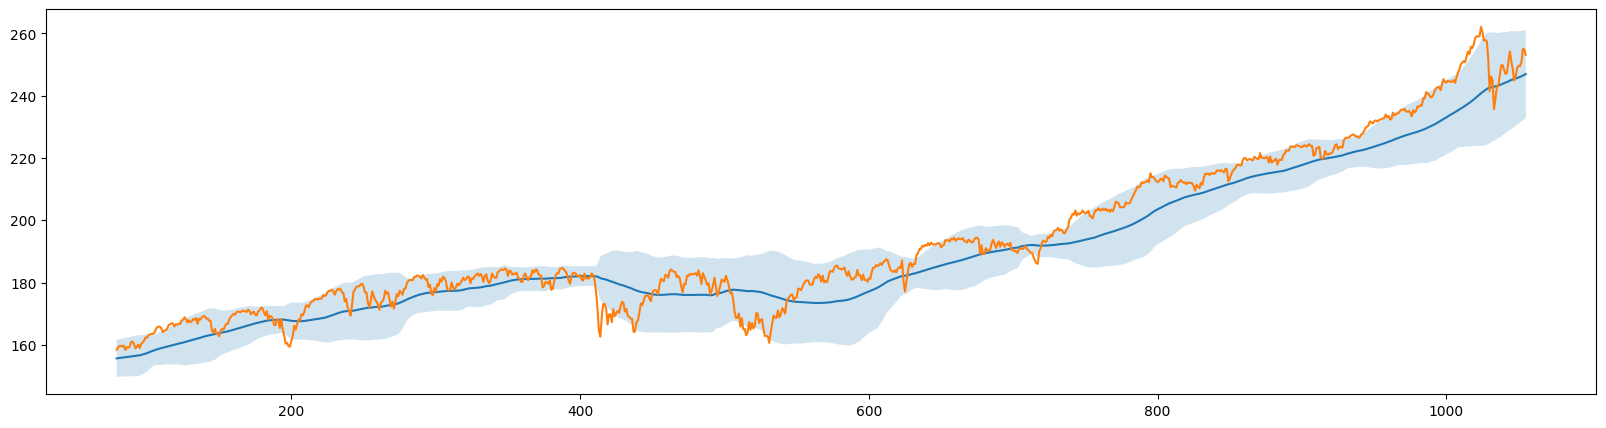

In [71]:
plt.plot(x_train[79:], rolling_mean)
plt.plot(x_train[79:], p_train[79:])

plt.fill_between(x_train[79:], rolling_mean - 2*rolling_std, rolling_mean + 2*rolling_std, alpha=0.2)